# The doubling population

Let's play with very simple scenario with a few (simple) mathematical models. The purpose of this exploration is not necessarily to explore the models, but rather to see various bits of Julia syntax and style for dealing with basic analysis.

**Say we observe or believe that every day the population doubles (and there are no deaths)**

Here are some 6 different models for this ...

### Model 1 (discrete time/deterministic)

$$
x(t+1) = \alpha x(t)
$$

with $\alpha = 2$.

### Model 2 (continuous time/deterministic)

$$
\frac{d}{dt} x(t) = \kappa x(t)
$$

with $\kappa = \log(\alpha) = \log(2) \approx 0.693$.

### Model 3 (discrete time/stochastic)

$$
x(t+1) = \sum_{i=1}^{x(t)} \xi_{i,t}
$$

with $E[\xi_{i,t}] = \alpha = 2$.

### Model 4 (continuous time/stochastic/continuous trajectory)

$$
du(t) = \kappa u(t) + d \zeta(t).
$$

And $x(t) = \max(u(t),0)$.

### Model 5 (continuous time/stochastic/discrete trajectory)

A continuous time markov chain with transition rates: $x \to x+1$ at rate $\kappa x$.

### Model 6 (continuous time/stochastic/discrete trajectory/non-Markovian)

A continuous time processs where each doubling per agent has their own distribution. Each agent lives for a duration which is $1$ day on average and then doubles.

Let's create trajectories for each of these models over the time horizon $[0,7]$. For the stochastic models lets compute mean trajectories. For those models let's also look at the distribution of $x(t=7)$. 

---

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/git/mine/Workshop_Julia_for_Biologists`


In [2]:
using Plots, DifferentialEquations, Distributions, Random
using StatsPlots, DataFrames, CSV

In [3]:
const α_const = 2 #\alpha + [TAB]
const κ_const = log(2) #\kappa + [TAB]
const default_t_max = 7
const default_x0 = 1.0;

In [4]:
"""
A generic structure that represents a model trajectory. 

* `t` is treated as an indexable object (array) of times.
* `u` is treated as an indexable object (array) or the trajectory.

This struct can be used in place of outputs of solvers of `DifferentialEquations.jl`
"""
struct ModelTrajectory
    t
    u
end

ModelTrajectory

In [5]:
? ModelTrajectory

search: ModelTrajectory



A generic structure that represents a model trajectory. 

  * `t` is treated as an indexable object (array) of times.
  * `u` is treated as an indexable object (array) or the trajectory.

This struct can be used in place of outputs of solvers of `DifferentialEquations.jl`


In [6]:
"""
Create a trajectory for model 1.
"""
function model_1_traj(;t_max = default_t_max, x0 = default_x0)
    traj = Array{Float64}(undef, t_max+1)
    x = x0
    traj[1] = x
    for t in 2:(t_max+1)
        x *= α_const
        traj[t] = x
    end
    return ModelTrajectory(0:t_max, traj)
end

model_1_traj

In [7]:
traj1 = model_1_traj()
traj1.t, traj1.u

(0:7, [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0])

Let's create a function for querying/interpolating a trajectory at any given time (within the time range).

In [8]:
function value_at_time(mt, time::Real) #mt is like ModelTrajectory assumed to have fields t, and u
    time < first(mt.t) && error("Time preceeds trajectory")
    i = findfirst((t)->t≥time, mt.t) 
    i == nothing && error("Time exceeds trajectory")
    t1, u1 = mt.t[i], mt.u[i]
    
    #if exact match of time 
    t1 == time && return u1

    #If here then interporlate
    @assert i > 1
    iprev = i-1
    tprev, uprev = mt.t[iprev], mt.u[iprev]
    return uprev + (time-tprev)/(t1-tprev) * (u1-uprev) #interpolate  
end

value_at_time (generic function with 1 method)

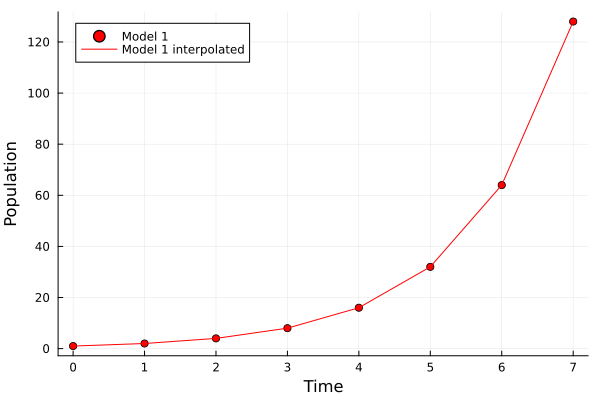

In [9]:
#Plotting Model 1
t_grid = 0:0.01:default_t_max
traj1_on_grid = [value_at_time(traj1,t1) for t1 in t_grid] 
p1 = scatter(traj1.t,traj1.u, 
            c=:red,legend=:topleft, xticks=0:7,
            label="Model 1",xlabel="Time",ylabel="Population")
p2 = plot(p1, t_grid, traj1_on_grid, c=:red,legend=:topleft,label="Model 1 interpolated")

### Moving onto Model 2, let's use ODE Solvers

In [10]:
function model_2_traj(;t_max = default_t_max, x0 = default_x0)
    f(x, p, t) = κ_const * x
    ode_prob = ODEProblem(f, x0, (0,t_max))
    ode_sol = solve(ode_prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)
    return ode_sol
end

model_2_traj (generic function with 1 method)

In [11]:
traj2 = model_2_traj()
traj2.t, traj2.u;

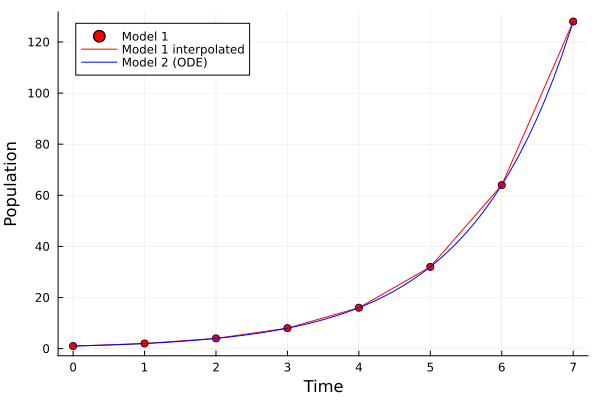

In [12]:
traj2_on_grid = [value_at_time(traj2,t1) for t1 in t_grid] 
p3 = plot(p2, t_grid, traj2_on_grid, c=:blue,legend=:topleft,label="Model 2 (ODE)")

# Going stochastic...

In [13]:
function model_3_traj(;t_max = default_t_max, 
                        x0 = default_x0, 
                        dist_by_mean_generator = Poisson,
                        seed::Union{Nothing,Int} = nothing)
    !isnothing(seed) && Random.seed!(seed)
    dist = dist_by_mean_generator(α_const)
    traj = Array{Float64}(undef, t_max+1)
    x = x0
    traj[1] = x
    for t in 2:(t_max+1)
        offsprings = [rand(dist) for _ in 1:x]
        x = isempty(offsprings) ? 0 : sum(offsprings)
        traj[t] = x
    end
    return ModelTrajectory(0:t_max, traj)
end

model_3_traj (generic function with 1 method)

In [14]:
traj3 = model_3_traj()

ModelTrajectory(0:7, [1.0, 3.0, 3.0, 6.0, 13.0, 17.0, 43.0, 82.0])

In [15]:
traj3_repeats = [model_3_traj().u for _ in 1:10^3]

1000-element Vector{Vector{Float64}}:
 [1.0, 2.0, 2.0, 3.0, 7.0, 20.0, 51.0, 143.0]
 [1.0, 4.0, 6.0, 12.0, 20.0, 29.0, 58.0, 102.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 1.0, 1.0, 3.0, 6.0, 15.0, 20.0, 54.0]
 [1.0, 2.0, 4.0, 10.0, 22.0, 46.0, 87.0, 175.0]
 [1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 3.0, 4.0]
 [1.0, 3.0, 5.0, 10.0, 16.0, 26.0, 50.0, 105.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 2.0, 6.0, 16.0, 36.0, 74.0, 149.0, 313.0]
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 1.0, 3.0, 4.0, 7.0, 11.0, 29.0, 53.0]
 [1.0, 3.0, 8.0, 12.0, 27.0, 53.0, 105.0, 212.0]
 [1.0, 3.0, 4.0, 9.0, 26.0, 60.0, 133.0, 264.0]
 ⋮
 [1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 11.0, 26.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 3.0, 10.0, 13.0, 23.0, 49.0, 103.0, 205.0]
 [1.0, 6.0, 18.0, 38.0, 87.0, 150.0, 293.0, 573.0]
 [1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 4.0, 10.0]
 [1.0, 2.0, 6.0, 11.0, 24.0, 43.0, 91.0, 184.0]
 [1.0, 2.0, 3.0, 7.0, 14.0, 31.0, 62.0, 111.0]
 [1.0, 4.0, 9.0, 19.0, 26.0, 63.0, 110.0

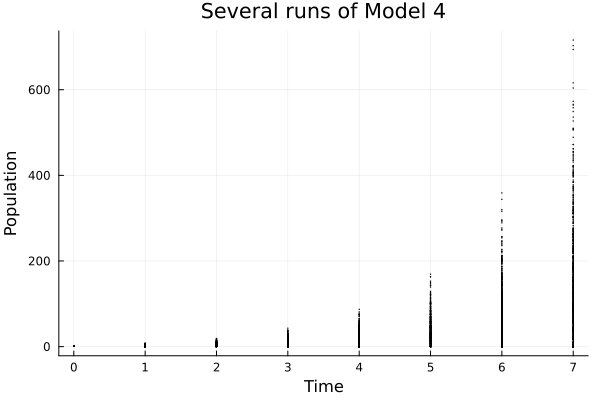

In [16]:
p4 = scatter(traj3.t, hcat(traj3_repeats...), 
        c=:black,ms=0.8,msw=0,legend=:topleft,label=false, xticks=0:7,
        xlabel="Time",ylabel="Population",
        title="Several runs of Model 4")

In [17]:
traj3_means = mean(traj3_repeats)

8-element Vector{Float64}:
   1.0
   2.083
   4.098
   8.144
  16.212
  32.597
  64.99
 130.346

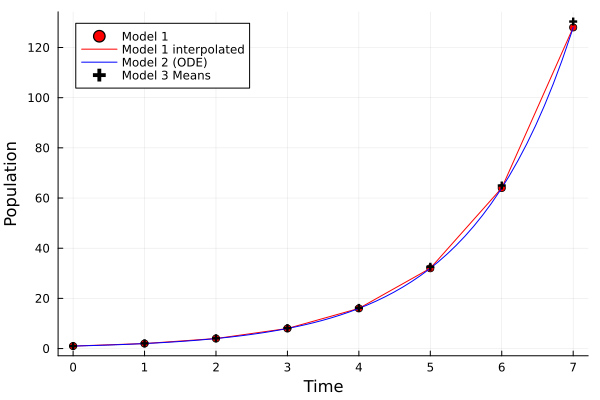

In [18]:
p4 = scatter(p3, traj3.t, traj3_means, c=:black,marker=:cross,legend=:topleft,msw=3,label="Model 3 Means")

Let's increase to a million repeats

  5.502205 seconds (9.05 M allocations: 1.525 GiB, 13.31% gc time, 0.53% compilation time)


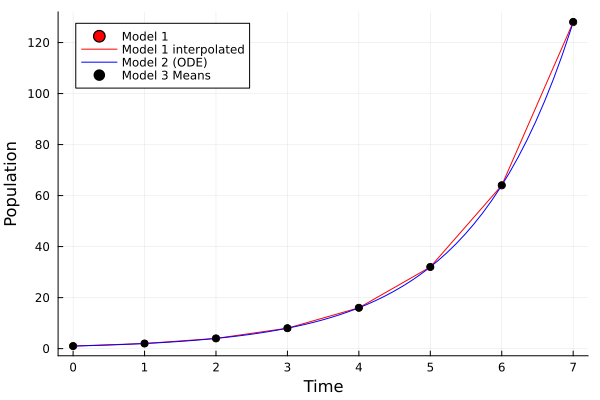

In [19]:
@time begin #See also BenchmarkTools.jl for better timing support
    traj3_repeats = [model_3_traj().u for _ in 1:10^6];
end
traj3_means = mean(traj3_repeats)
p5 = scatter(p3, traj3.t, traj3_means, c=:black,marker=:black,legend=:topleft,msw=2,label="Model 3 Means")

### Now SDE

In [20]:
function model_4_traj(;t_max = default_t_max, x0 = default_x0, dt = 1//2^(4), positive_only = false)
    x0 = rand(Normal(x0, 1))
    f(u,p,t) = κ_const*u
    g(u,p,t) = u > 0 ? 1 : 0
    sode_prob = SDEProblem(f,g,x0,(0.0,t_max))
    sode_sol = solve(sode_prob, EM(), dt=dt)
    positive_only ? ModelTrajectory(sode_sol.t, map((u)->max(u,0), sode_sol.u) ) : sode_sol
end

model_4_traj (generic function with 1 method)

In [21]:
traj4_t = model_4_traj().t
first(traj4_t,5)

5-element Vector{Float64}:
 0.0
 0.0625
 0.125
 0.1875
 0.25

In [22]:
traj4_repeats_a = [model_4_traj().u for _ in 1:10^2];
traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^2];

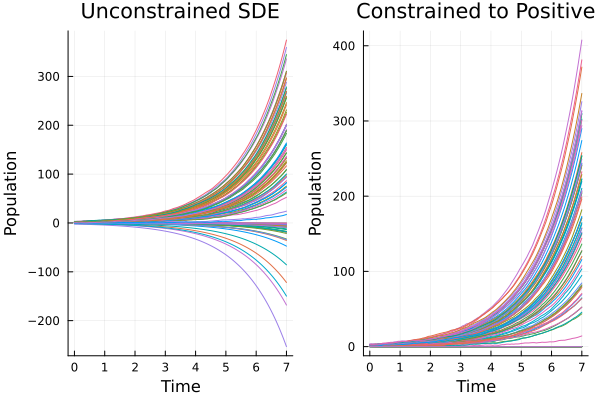

In [23]:
plot_args = (legend=false,xlabel="Time",ylabel="Population", xticks = 0:7)
pa = plot(traj4_t, hcat(traj4_repeats_a...), title = "Unconstrained SDE"; plot_args...)
pb = plot(traj4_t, hcat(traj4_repeats_b...), title = "Constrained to Positive"; plot_args...)
plot(pa,pb)

In [24]:
@time traj4_repeats_a = [model_4_traj().u for _ in 1:10^5];
@time traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^5];
@time traj4_means_a = mean(traj4_repeats_a)
@time traj4_means_b = mean(traj4_repeats_b)
first(traj4_means_a,3), first(traj4_means_b,3)

  2.052960 seconds (12.85 M allocations: 777.078 MiB, 7.31% gc time, 1.97% compilation time)
  2.538576 seconds (13.38 M allocations: 894.662 MiB, 6.31% gc time, 2.31% compilation time)
  0.113199 seconds (100.00 k allocations: 96.131 MiB, 53.03% gc time)
  0.071937 seconds (100.00 k allocations: 96.131 MiB)


([1.0012265872043333, 1.0448411116858174, 1.0907743511351353], [1.0821350810148067, 1.1326998853790178, 1.1848672118377663])

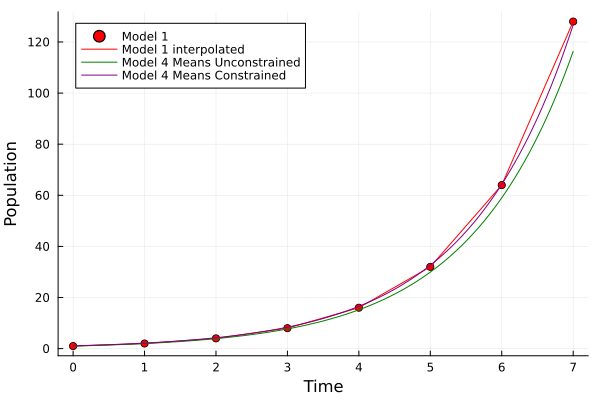

In [25]:
plot(p2, traj4_t, [traj4_means_a traj4_means_b], 
                c=[:green :purple], legend=:topleft, msw=0, 
                label=["Model 4 Means Unconstrained" "Model 4 Means Constrained"])

# Storing results/data in file

Say we want to store results at times:

In [26]:
times_of_results = [0.0, 2.5, 5.9, 6.7]

4-element Vector{Float64}:
 0.0
 2.5
 5.9
 6.7

In [27]:
model4df = DataFrame()
sims = [model_4_traj(positive_only=true) for _ in 1:10^2];
for time in times_of_results
    model4df[:,replace("Time$time","." => "_")] = [value_at_time(sim, time) for sim in sims]
end

In [28]:
CSV.write("model4.csv",model4df)

"model4.csv"

### Continuous Time Markov Chain (Markov Jump Process)

In [29]:
function model_5_traj(;t_max = default_t_max, x0 = default_x0)
    t, x = 0.0 , x0
    t_values, u_values = [t], [x]
    while t < t_max
        t += rand(Exponential(1/(x*κ_const)))
        x += 1
        push!(t_values,t)
        push!(u_values,x)
    end
    return ModelTrajectory(t_values, u_values)
end

model_5_traj (generic function with 1 method)

In [30]:
traj5 = model_5_traj()
traj5.t, traj5.u

([0.0, 2.085792796613497, 2.2467218897304053, 2.753704319347248, 2.9044120464041843, 3.3761289996882335, 3.3869819945922823, 3.659844425350168, 3.6603655373350605, 3.787982622889391  …  6.690961976098955, 6.723636773566192, 6.760948230180117, 6.802438252294363, 6.845934460361708, 6.900870001402721, 6.911979510502244, 6.929208971435201, 6.940732322887854, 7.009483252555256], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0])

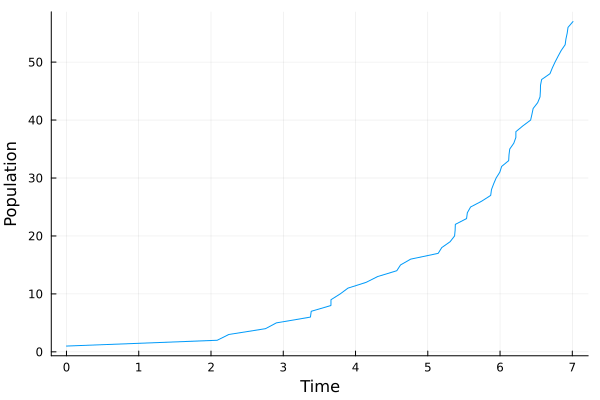

In [31]:
#Plotting of the trajectory for Model 5 - but something is a bit wrong... (what is it?)
plot(traj5.t, traj5.u;plot_args...)

In [32]:
#Function helping plotting
function stich_steps(model_trajectory)
    t, u = model_trajectory.t, model_trajectory.u
    n = length(t)
    new_t  = [ t[1] ]
    new_u = [ u[1] ]
    for i in 2:n
        push!(new_t, t[i])
        push!(new_u, u[i-1])
        push!(new_t, t[i])
        push!(new_u, u[i])
    end
    return ModelTrajectory(new_t, new_u)
end

stich_steps (generic function with 1 method)

In [33]:
traj5_stiched = stich_steps(traj5)

ModelTrajectory([0.0, 2.085792796613497, 2.085792796613497, 2.2467218897304053, 2.2467218897304053, 2.753704319347248, 2.753704319347248, 2.9044120464041843, 2.9044120464041843, 3.3761289996882335  …  6.900870001402721, 6.900870001402721, 6.911979510502244, 6.911979510502244, 6.929208971435201, 6.929208971435201, 6.940732322887854, 6.940732322887854, 7.009483252555256, 7.009483252555256], [1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0  …  52.0, 53.0, 53.0, 54.0, 54.0, 55.0, 55.0, 56.0, 56.0, 57.0])

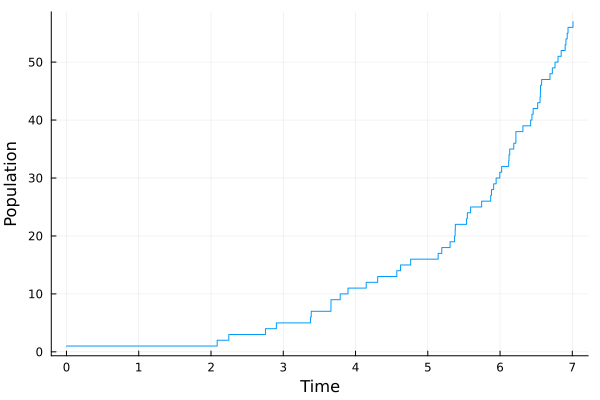

In [34]:
plot(traj5_stiched.t, traj5_stiched.u, legend=false;plot_args...)

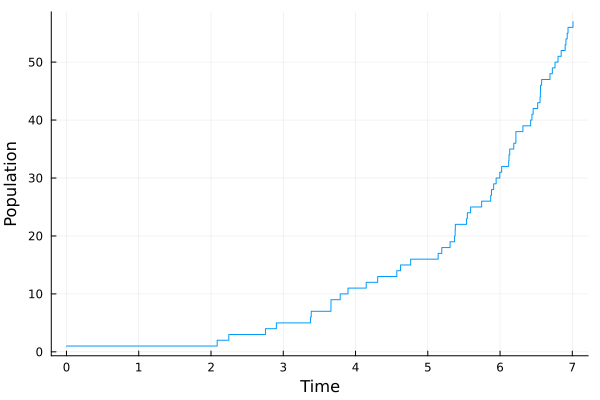

In [35]:
plot(traj5_stiched.t, traj5_stiched.u, legend=false;plot_args...)

In [36]:
traj5_repeats = [model_5_traj() for _ in 1:10];
traj5_repeats_stiched = stich_steps.(traj5_repeats)
# @time traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^5];
# @time traj4_means_a = mean(traj4_repeats_a)
# @time traj4_means_b = mean(traj4_repeats_b)
# first(traj4_means_a,3), first(traj4_means_b,3)

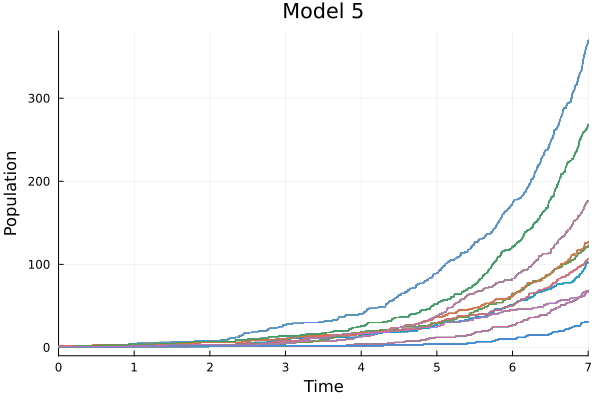

In [37]:
times = [mt.t for mt in traj5_repeats_stiched]
vals = [mt.u for mt in traj5_repeats_stiched]
p = plot(title = "Model 5")
for i in 1:length(times)
    plot!(times,vals;plot_args...,xlim=(0,7))
end
p

In [38]:
function value_at_time(mt, time::Real, jump_process::Bool=true) 
    time < first(mt.t) && error("Time preceeds trajectory")
    i = findfirst((t)->t≥time, mt.t) 
    i == nothing && error("Time exceeds trajectory")
    
    #if exact match of time 
    mt.t[i] == time && return mt.u[i]

    #Otherwise prev time...
    @assert i > 1
    return mt.u[i-1]    
end

value_at_time (generic function with 2 methods)

In [39]:
methods(value_at_time)

# 2 methods for generic function "value_at_time":
[1] value_at_time(mt, time::Real) in Main at In[38]:1
[2] value_at_time(mt, time::Real, jump_process::Bool) in Main at In[38]:1

In [40]:
Random.seed!(0)
traj5 = model_5_traj()

ModelTrajectory([0.0, 1.4555369011918016, 1.528580982636026, 1.9312783105482008, 2.048463811926414, 2.2645397537731813, 2.3632855702197126, 2.4085306574750978, 2.4325789130379603, 2.4518622060619695  …  6.946142846996933, 6.948893600367086, 6.95218686810082, 6.957170676074483, 6.9593554658737435, 6.959496504076371, 6.982206772066854, 6.990601021397845, 6.999642565836232, 7.005596967597079], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  257.0, 258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0])

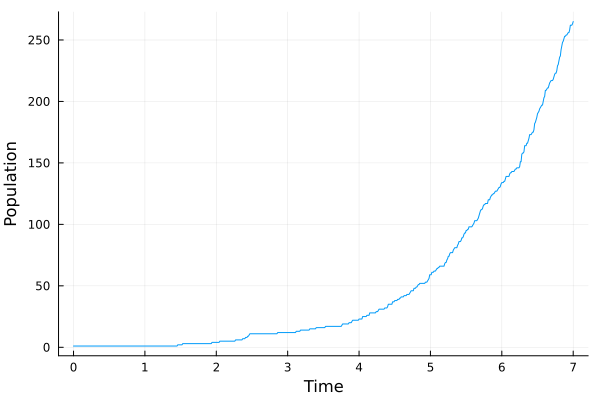

In [41]:
t_grid = 0:0.01:7
vals = [value_at_time(traj5, t ,true) for t in t_grid]
plot(t_grid,vals;plot_args...)

  0.070764 seconds (122.26 k allocations: 61.842 MiB, 43.08% compilation time)


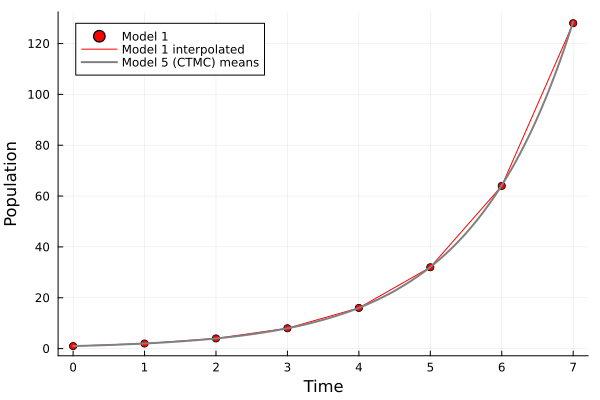

In [42]:
@time trajs = [model_5_traj() for _ in 1:10^4]
means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
plot(p2,t_grid,means,lw=2,c=:grey,label="Model 5 (CTMC) means")

┌ Info: Saved animation to /Users/uqjnazar/git/mine/Workshop_Julia_for_Biologists/sampleAnim.gif
└ @ Plots /Users/uqjnazar/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/uqjnazar/git/mine/Workshop_Julia_for_Biologists/sampleAnim.gif")
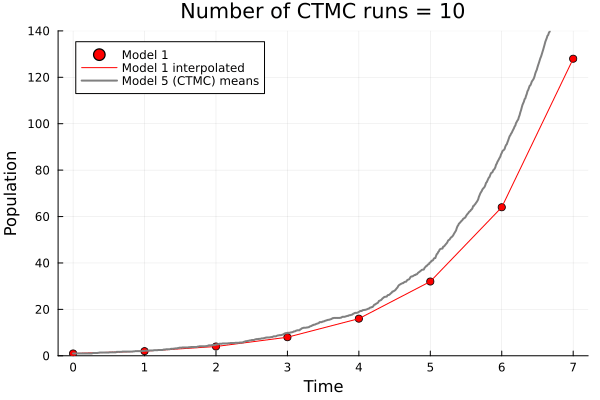

In [54]:
anim = Animation()
for N in [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 10000]
    Random.seed!(0)
    trajs = [model_5_traj() for _ in 1:N]
    means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
    plot(p2,t_grid,means,lw=2,c=:grey,ylim=(0,140),label="Model 5 (CTMC) means", title = "Number of CTMC runs = $N")
    frame(anim)
end

gif(anim, "sampleAnim.gif", fps = 1.5)

# Model 6 - Agent/Discrete-Event

In [44]:
function model_6_traj(;t_max = 10, x0 = 1, life_time_till_doubling_dist = Exponential)
    lives =[]
    t, x = 0.0 , x0
    t_values, u_values = [t], [x]
    while t < t_max
        t += rand(Exponential(1/(x*κ_const)))
        x += 1
        push!(t_values,t)
        push!(u_values,x)
    end
    return ModelTrajectory(t_values, u_values)
end

model_6_traj (generic function with 1 method)

# An Experiment

In [45]:
t4s = [model_3_traj().u[3+1] for _ in 1:10^4];

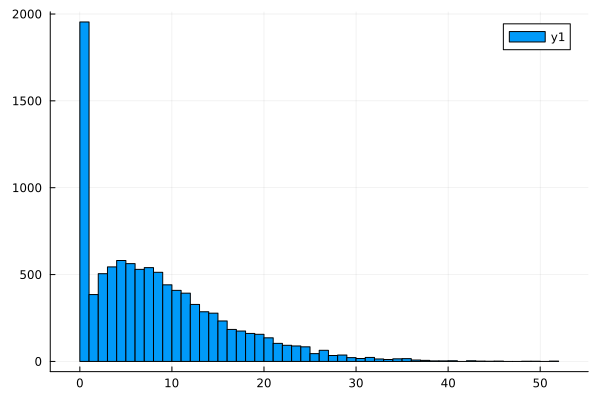

In [46]:
histogram(t4s)

In [47]:
trj = model_4_traj()

retcode: Success
Interpolation: 1st order linear
t: 113-element Vector{Float64}:
 0.0
 0.0625
 0.125
 0.1875
 0.25
 0.3125
 0.375
 0.4375
 0.5
 0.5625
 0.625
 0.6875
 0.75
 ⋮
 6.3125
 6.375
 6.4375
 6.5
 6.5625
 6.625
 6.6875
 6.75
 6.8125
 6.875
 6.9375
 7.0
u: 113-element Vector{Float64}:
   2.499549519538423
   2.2134379950935616
   2.246455932464838
   2.1671533720121916
   2.062295654693798
   1.766300118785038
   2.0411732135364242
   1.897726007793372
   2.02756887823271
   2.073488039889044
   2.64697449495271
   2.7232083499661455
   2.8924412232218346
   ⋮
 112.29989119682514
 117.29722500654081
 122.31597549742052
 127.49695368275181
 132.89290531559865
 138.76202775003458
 144.778300508141
 150.87864086537502
 157.80526649973442
 164.6269312762408
 171.81088789930382
 179.0721882809685

In [48]:
findnext((x)->x ≥ 4, trj.t,1)

65

In [49]:
trj.t[63], trj.t[66]

(3.875, 4.0625)

In [50]:
? findfirst

search: findfirst



```
findfirst(A)
```

Return the index or key of the first `true` value in `A`. Return `nothing` if no such value is found. To search for other kinds of values, pass a predicate as the first argument.

Indices or keys are of the same type as those returned by [`keys(A)`](@ref) and [`pairs(A)`](@ref).

See also: [`findall`](@ref), [`findnext`](@ref), [`findlast`](@ref), [`searchsortedfirst`](@ref).

# Examples

```jldoctest
julia> A = [false, false, true, false]
4-element Vector{Bool}:
 0
 0
 1
 0

julia> findfirst(A)
3

julia> findfirst(falses(3)) # returns nothing, but not printed in the REPL

julia> A = [false false; true false]
2×2 Matrix{Bool}:
 0  0
 1  0

julia> findfirst(A)
CartesianIndex(2, 1)
```

---

```
findfirst(predicate::Function, A)
```

Return the index or key of the first element of `A` for which `predicate` returns `true`. Return `nothing` if there is no such element.

Indices or keys are of the same type as those returned by [`keys(A)`](@ref) and [`pairs(A)`](@ref).

# Examples

```jldoctest
julia> A = [1, 4, 2, 2]
4-element Vector{Int64}:
 1
 4
 2
 2

julia> findfirst(iseven, A)
2

julia> findfirst(x -> x>10, A) # returns nothing, but not printed in the REPL

julia> findfirst(isequal(4), A)
2

julia> A = [1 4; 2 2]
2×2 Matrix{Int64}:
 1  4
 2  2

julia> findfirst(iseven, A)
CartesianIndex(2, 1)
```

---

```
findfirst(pattern::AbstractString, string::AbstractString)
findfirst(pattern::AbstractPattern, string::String)
```

Find the first occurrence of `pattern` in `string`. Equivalent to [`findnext(pattern, string, firstindex(s))`](@ref).

# Examples

```jldoctest
julia> findfirst("z", "Hello to the world") # returns nothing, but not printed in the REPL

julia> findfirst("Julia", "JuliaLang")
1:5
```

---

```
findfirst(ch::AbstractChar, string::AbstractString)
```

Find the first occurrence of character `ch` in `string`.

!!! compat "Julia 1.3"
    This method requires at least Julia 1.3.


# Examples

```jldoctest
julia> findfirst('a', "happy")
2

julia> findfirst('z', "happy") === nothing
true
```

---

```
findfirst(pattern::AbstractVector{<:Union{Int8,UInt8}},
          A::AbstractVector{<:Union{Int8,UInt8}})
```

Find the first occurrence of sequence `pattern` in vector `A`.

!!! compat "Julia 1.6"
    This method requires at least Julia 1.6.


# Examples

```jldoctest
julia> findfirst([0x52, 0x62], [0x40, 0x52, 0x62, 0x63])
2:3
```


# Saving Experimental Results

In [51]:
df = DataFrame()

0×0 DataFrame

In [52]:
df[:,"hello"] = [1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [53]:
df

Row,hello
,Int64
1,1
2,2
3,3
